In [ ]:
from schrodinger.application.desmond.packages import traj_util, traj, topo
#from schrodinger.application.desmond.packages import traj_util, traj, topo
import numpy as np
import pandas as pd

import os
cms_path = os.path.expanduser('~/Dropbox/KcsA/kcsa_5000ns_1218/kcsa_deactivated_5us_centered-out.cms')
traj_path = os.path.expanduser('~/Dropbox/KcsA/kcsa_5000ns_1218/kcsa_deactivated_5us_centered_trj')

# Load structure and trajectory (paths to your .cms and .trj files)
_, cms_model = topo.read_cms(cms_path)
trajectory = traj.read_traj(traj_path)

# Select backbone atoms: carbonyl carbon (C), oxygen (O), and amide nitrogen (N)
c_aids = cms_model.select_atom("chain.name A and res.num 76 and atom.ptype C")
o_aids = cms_model.select_atom("chain.name A and res.num 76 and atom.ptype O")
n_aids = cms_model.select_atom("chain.name A and res.num 76 and atom.ptype N")

#print(c_aids)

# Map atom IDs to global IDs for trajectory processing
gid_C_list = topo.aids2gids(cms_model, c_aids)
gid_O_list = topo.aids2gids(cms_model, o_aids)
gid_N_list = topo.aids2gids(cms_model, n_aids)

# Ensure the lists are of equal length (one-to-one correspondence)
assert len(gid_C_list) == len(gid_O_list) == len(gid_N_list), "Mismatch in atom selections."

# Initialize lists to accumulate orientation vectors over time
sigma_33_list, sigma_22_list, sigma_11_list = [], [], []

# Loop through trajectory frames
for frame in trajectory:
    # Process each residue (assume one-to-one correspondence of C, O, N per residue)
    for gid_C, gid_O, gid_N in zip(gid_C_list, gid_O_list, gid_N_list):
        # Extract atomic positions
        C = frame.pos(gid_C)
        #print(C)
        O = frame.pos(gid_O)
        #print(O)
        N = frame.pos(gid_N)
        #print(N)

        # Build local molecular frame
        vec_CO = O - C
        sigma_22 = vec_CO / np.linalg.norm(vec_CO)  # Along CO bond

        # Normal vector to peptide plane (C', O, N)
        vec_CN = N - C
        sigma_33 = np.cross(vec_CO, vec_CN)  # Perpendicular to peptide plane
        sigma_33 /= np.linalg.norm(sigma_33)

        # Orthogonal axis
        sigma_11 = np.cross(sigma_33, sigma_22)  # Orthogonal to sigma_33 and sigma_22
        sigma_11 /= np.linalg.norm(sigma_11)

        # Append to orientation lists
        sigma_33_list.append(sigma_33)
        sigma_22_list.append(sigma_22)
        sigma_11_list.append(sigma_11)

# Post-processing: Save or analyze the accumulated orientation data
sigma_33_array = np.array(sigma_33_list)
sigma_22_array = np.array(sigma_22_list)
sigma_11_array = np.array(sigma_11_list)

#print(sigma_33_array.shape)



frame_times = np.array([fr.time for fr in trajectory])  # Extract time for each frame in the trajectory

# Create a DataFrame
df = pd.DataFrame({
    'Frame': np.arange(len(frame_times)),  # Frame indices
    'Time (ps)': frame_times,             # Trajectory time
    'Sigma_33_X': sigma_33_array[:,0],   # X-component of Sigma_33
    'Sigma_33_Y': sigma_33_array[:,1],   # Y-component of Sigma_33
    'Sigma_33_Z': sigma_33_array[:,2],   # Z-component of Sigma_33
    'Sigma_22_X': sigma_22_array[:,0],   # X-component of Sigma_22
    'Sigma_22_Y': sigma_22_array[:,1],   # Y-component of Sigma_22
    'Sigma_22_Z': sigma_22_array[:,2],   # Z-component of Sigma_22
    'Sigma_11_X': sigma_11_array[:,0],   # X-component of Sigma_11
    'Sigma_11_Y': sigma_11_array[:,1],   # Y-component of Sigma_11
    'Sigma_11_Z': sigma_11_array[:,2],   # Z-component of Sigma_11
})

# Save the DataFrame to an Excel file
output_file = "orientation_vectors.xlsx"
df.to_excel(output_file, index=False)

print(f"Orientation data saved to {output_file}")

<ipython-input-1-1e19107a5bc2>:90: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.9' currently installed).
  df.to_excel(output_file, index=False)


In [ ]:
#read orientation_vector.xlsx
import pandas as pd
ori_pd = pd.read_excel('orientation_vectors.xlsx')
#sigma_33_array

In [4]:
# from the local frame, we can calculate the rotation matrix from local frame to lab frame
sigma11= 240   #
sigma22= 190   # y
sigma33= 95

csa_principle=[[240,0, 0],[0,190,0],[0,0,95]]
#print(sigma_33_array.shape)
print(sigma_33_array[0])
print(sigma_22_array[0])
print(sigma_11_array[0])

r_t = np.stack((sigma_33_array,sigma_22_array,sigma_11_array),axis=-1)
r_t = np.transpose(r_t, axes=(0, 2, 1))
print(r_t[0,:])  # to verify the rotation matrix is right

# now calculat sigma(t)

sigma_t = np.einsum('nij,jk,nkl->nil', r_t, csa_principle, r_t.transpose(0, 2, 1))

[-0.20971954 -0.91157365 -0.35362566]
[ 0.7928684   0.05309229 -0.6070757 ]
[ 0.57216907 -0.40769428  0.7116235 ]
[[-0.20971954 -0.91157365 -0.35362566]
 [ 0.7928684   0.05309229 -0.6070757 ]
 [ 0.57216907 -0.40769428  0.7116235 ]]


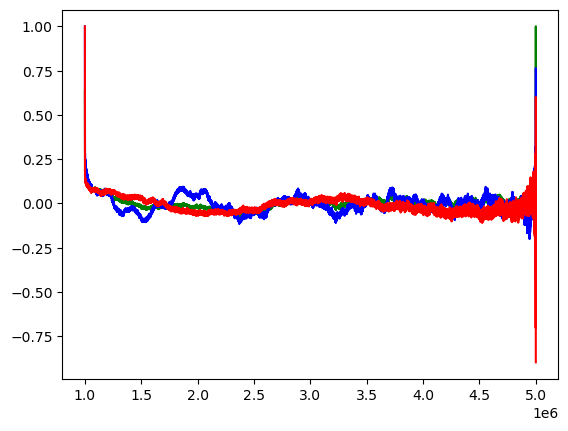

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# calcualte theta using sigma_33_axis
#sigma33_axis_array * [0, 0, 1]           # shape (Nframes,3)

def autocorrelation(vector_axis):
    '''
    calculate autocorrelation function
    input:
    output:
    '''
    
    cos2 = vector_axis[:,2]**2                 # z-component squared
#Delta_sigma = 240-(95+190)/2 *10**(-6)
    Delta_sigma =1
    A = (3*cos2 - 1) * (Delta_sigma) / 2.0  # CSA interaction sequence

    # Autocorrelation (unnormalized, one-sided)
    N = len(A)
    A_mean = np.mean(A)
    acf = np.array([np.mean((A[:N-k]-A_mean)*(A[k:]-A_mean)) for k in range(N)])
    return acf
#sigma_t_33_mean = np.mean(sigma_t[:,2,2])
#acf_2 = np.array([np.mean((sigma_t[:,2,2][:N-k]-sigma_t_33_mean)*(sigma_t[:,2,2][k:]-sigma_t_33_mean)) for k in range(N)])
acf_11=autocorrelation(sigma_11_array)
acf_22=autocorrelation(sigma_22_array)
acf_33=autocorrelation(sigma_33_array)

plt.plot(frame_times, acf_11/acf_11.max(),c='g')
plt.plot(frame_times, acf_22/acf_22.max(),c='b')
plt.plot(frame_times, acf_33/acf_33.max(),c='r')
#plt.plot(frame_times, acf_2/acf_2.max(), label='sigma_t')
plt.show()


In [ ]:
# fit the correlation time with model c(t)= 
# to calculate NMR relaxation parameters, we have equation:
# 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def correlation_function(t, time_scales, amplitudes=None):
    """
    Calculate the correlation function with multiple time scales.
    
    Parameters:
    - t: np.ndarray
        Array of time points.
    - time_scales: list or np.ndarray
        List of time scales (τ) for the exponential decay terms.
    - amplitudes: list or np.ndarray, optional
        Amplitudes corresponding to each time scale. If None, they are normalized.
    
    Returns:
    - np.ndarray: Correlation function values at each time point.
    """
    num_scales = len(time_scales)
    if amplitudes is None:
        # Assign equal weight to all time scales if amplitudes are not provided
        amplitudes = np.ones(num_scales) / num_scales
    else:
        # Normalize amplitudes to sum to 1
        amplitudes = np.array(amplitudes) / np.sum(amplitudes)
    
    # Sum over multiple exponential decays
    correlation = np.sum([
        amp * np.exp(-t / tau) for amp, tau in zip(amplitudes, time_scales)
    ], axis=0)
    return correlation

def generate_correlation_model(num_scales, t_max=10, num_points=1000):
    """
    Generate and plot a correlation function model with multiple time scales.
    
    Parameters:
    - num_scales: int
        Number of time scales to include in the model.
    - t_max: float
        Maximum time value for the time points.
    - num_points: int
        Number of time points for the model.
    
    Returns:
    - None: Plots the correlation function.
    """
    # Generate time points
    t = np.linspace(0, t_max, num_points)
    
    # Randomly generate time scales and amplitudes
    time_scales = np.logspace(-1, 1, num_scales)  # Logarithmic range of time scales
    amplitudes = np.random.random(num_scales)    # Random amplitudes
    amplitudes /= np.sum(amplitudes)             # Normalize amplitudes
    
    # Calculate the correlation function
    correlation = correlation_function(t, time_scales, amplitudes)
    
    # Plot the correlation function
    plt.figure(figsize=(8, 6))
    plt.plot(t, correlation, label=f'{num_scales} time scales')
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.title('Correlation Function with Multiple Time Scales')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Print details
    print("Time Scales (τ):", time_scales)
    print("Amplitudes:", amplitudes)

# Example Usage
num_scales = 3  # Input: Number of time scales
generate_correlation_model(num_scales)


Time Scales (τ): [ 0.1  1.  10. ]
Amplitudes: [0.3729851  0.16594515 0.46106974]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the correlation function model
def correlation_function(t, *params):
    """
    Correlation function model with multiple time scales.
    Parameters are alternating amplitudes and time scales.
    
    Parameters:
    - t: np.ndarray
        Time points.
    - params: tuple
        Alternating amplitudes and time scales.
        Example: (amp1, tau1, amp2, tau2, ...)
    
    Returns:
    - np.ndarray: Correlation function values.
    """
    num_scales = len(params) // 2
    correlation = np.zeros_like(t)
    for i in range(num_scales):
        amp = params[2 * i]
        tau = params[2 * i + 1]
        correlation += amp * np.exp(-t / tau)
    return correlation

# Generate synthetic data for fitting
def generate_synthetic_data(num_scales, t_max=10, num_points=1000, noise_level=0.01):
    """
    Generate synthetic data with noise for testing the fitting.
    
    Parameters:
    - num_scales: int
        Number of time scales.
    - t_max: float
        Maximum time.
    - num_points: int
        Number of data points.
    - noise_level: float
        Standard deviation of Gaussian noise.
    
    Returns:
    - t: np.ndarray
        Time points.
    - y: np.ndarray
        Correlation function values with noise.
    - true_params: list
        True amplitudes and time scales used to generate the data.
    """
    t = np.linspace(0, t_max, num_points)
    time_scales = np.logspace(-1, 1, num_scales)
    amplitudes = np.random.random(num_scales)
    amplitudes /= np.sum(amplitudes)  # Normalize amplitudes
    true_params = []
    for amp, tau in zip(amplitudes, time_scales):
        true_params.extend([amp, tau])
    y = correlation_function(t, *true_params)
    y += np.random.normal(0, noise_level, size=y.shape)
    return t, y, true_params

# Fit data to the correlation function model
def fit_correlation_model(t, y, num_scales):
    """
    Fit the correlation function model to data.
    
    Parameters:
    - t: np.ndarray
        Time points.
    - y: np.ndarray
        Observed data points.
    - num_scales: int
        Number of time scales in the model.
    
    Returns:
    - fitted_params: np.ndarray
        Fitted amplitudes and time scales.
    - covariance: np.ndarray
        Covariance matrix of the fit.
    """
    # Initial guesses: random amplitudes and logarithmic time scales
    initial_amplitudes = np.random.random(num_scales)
    initial_amplitudes /= np.sum(initial_amplitudes)
    initial_time_scales = np.logspace(-1, 1, num_scales)
    initial_guess = []
    for amp, tau in zip(initial_amplitudes, initial_time_scales):
        initial_guess.extend([amp, tau])
    
    # Fit the model
    fitted_params, covariance = curve_fit(
        correlation_function, t, y, p0=initial_guess
    )
    return fitted_params, covariance

# Example Usage
num_scales = 3
t, y, true_params = generate_synthetic_data(num_scales)

fitted_params, covariance = fit_correlation_model(t, y, num_scales)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, y, label="Synthetic Data (with noise)", alpha=0.7)
plt.plot(t, correlation_function(t, *true_params), label="True Model", linestyle="--")
plt.plot(t, correlation_function(t, *fitted_params), label="Fitted Model")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("Fit Correlation Function with Multiple Time Scales")
plt.legend()
plt.grid()
plt.show()

# Print results
print("True Parameters (Amplitudes and Time Scales):", true_params)
print("Fitted Parameters (Amplitudes and Time Scales):", fitted_params)


True Parameters (Amplitudes and Time Scales): [0.46705525452010055, 0.1, 0.31692822179231606, 1.0, 0.21601652368758342, 10.0]
Fitted Parameters (Amplitudes and Time Scales): [0.46015161 0.09669554 0.32322045 0.96697894 0.21816441 9.9585243 ]


In [3]:

# Time step (ps) between frames; convert to s if needed for SI units
dt = 200 *10**(-12)  # e.g. 200 ps per frame or fr.time attribute
# Compute FFT of acf (use one-sided convention)
J_full = np.real(np.fft.rfft(acf)) * dt
freq = np.fft.rfftfreq(N, dt)  # cycles per ps
omega = 2*np.pi * freq         # rad per ps

gamma13 = 2*np.pi * 10.705e6  # rad/T/s (gyromag ratio 13C)
B0 = 600  # 600 MegaHz
omega0 = gamma13 * B0         # rad/s

# Convert anisotropy (ppm) to rad/s: sigma_rad = Delta_sigma_ppm * omega0 * 1e-6
sigma_rad = Delta_sigma* omega0 
R1 = (2.0/15.0) * (omega0**2) * (sigma_rad**2) * J_omega0
T1 = 1.0 / R1


NameError: name 'acf' is not defined

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Simulated autocorrelation function (replace with real C(t))
time = np.linspace(0, 10, 1000)  # Time points (ps)
C_t = np.exp(-time / 1.0)        # Exponential decay, example ACF

# Frequency range for spectral density
frequencies = np.linspace(0, 10, 500)  # Frequency range (rad/ps)
J_omega = []

# Compute spectral density using the Fourier relation
for omega in frequencies:
    J = np.trapz(C_t * np.cos(omega * time), time)  # Numerical integration
    J_omega.append(J)

# Plot spectral density
plt.plot(frequencies, J_omega, label="Spectral Density")
plt.xlabel("Frequency (rad/ps)")
plt.ylabel("J(ω)")
plt.legend()
plt.title("Spectral Density from Autocorrelation")
plt.show()
